In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import copy
import jax.numpy as jnp
from scipy.optimize import curve_fit
import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.udf.com import CoMUDF, RegressionOptions
from libertem.udf.masks import ApplyMasksUDF
from skimage.measure import label, regionprops
from concurrent.futures import ProcessPoolExecutor
import microscope_calibration.components as comp
from microscope_calibration.model import ModelParameters, DescannerErrorParameters, create_stem_model
from microscope_calibration.generate import generate_dataset_from_image
from microscope_calibration.interactive import interactive_window
from microscope_calibration.fitting import fit_descan_error_matrix
from microscope_calibration.stemoverfocus import solve_model_fourdstem_wrapper

In [2]:
def descan_error_params_random():
    # Randomize descan error parameters
    return DescannerErrorParameters(
        pxo_pxi=np.random.uniform(-4.0, 4.0),
        pxo_pyi=np.random.uniform(-4.0, 4.0),
        pyo_pxi=np.random.uniform(-4.0, -4.0),
        pyo_pyi=np.random.uniform(-4.0, 4.0),
        sxo_pxi=np.random.uniform(-4.0, 4.0),
        sxo_pyi=np.random.uniform(-4.0, 4.0),
        syo_pxi=np.random.uniform(-4.0, 4.0),
        syo_pyi=np.random.uniform(-4.0, 4.0),
        offpxi=np.random.uniform(-0.04, 0.04),
        offsxi=np.random.uniform(-0.04, 0.04),
        offpyi=np.random.uniform(-0.04, 0.04),
        offsyi=np.random.uniform(-0.04, 0.04)
    )

In [3]:
# That that we can fit the descan error parameters
# generated from propagating a single pixel with
# descan error.

ctx = lt.Context.make_with("inline")

scan_shape = (41, 41)
det_shape = (129, 129)
scan_step = (0.0005, 0.0005)
det_px_size = (0.01, 0.01)

test_image = np.ones(scan_shape, dtype=np.uint8)

descan_error = descan_error_params_random()

params = ModelParameters(
    semi_conv=1e-1,
    defocus=0.01,
    camera_length=0.5,
    scan_shape=scan_shape,
    det_shape=det_shape,
    scan_step=scan_step,
    det_px_size=det_px_size,
    scan_rotation=0.0,
    descan_error=descan_error,
    flip_y=False,
)

datasets = {}
clengths = (0.5, 1.0, 1.5)
with ProcessPoolExecutor(max_workers=3) as p:
    futures = []
    for cl in clengths:
        _params = copy.deepcopy(params)
        _params["camera_length"] = cl
        f = p.submit(generate_dataset_from_image, _params, test_image, method="linear", sample_scale=1.0, progress=False)
        futures.append(f)
    
    for f, cl in zip(futures, clengths):
        data = f.result()
        datasets[cl] = ctx.load("memory", data=data, num_partitions=1)

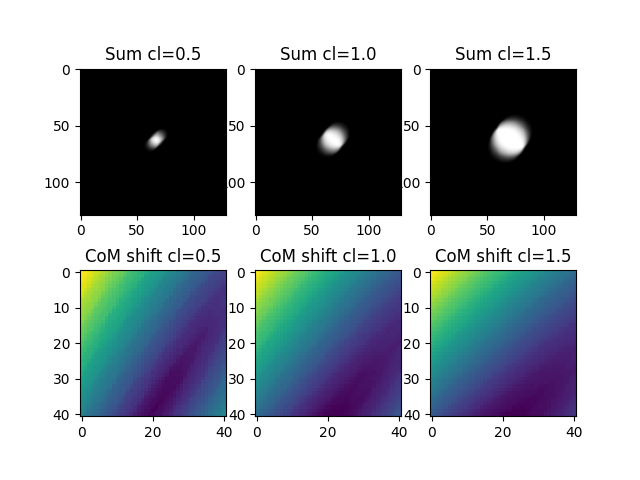

In [4]:
fig, axs = plt.subplots(2, 3)

com_r = {}
com_udf = CoMUDF.with_params()
for i, (cl, ds) in enumerate(datasets.items()):
    sum_res, com_res = ctx.run_udf(ds, [SumUDF(), com_udf])
    com_r[cl] = com_res
    axs[0, i].imshow(sum_res["intensity"].data, cmap="gray")
    axs[0, i].set_title(f"Sum cl={cl}")
for i, (cl, ds) in enumerate(datasets.items()):
    axs[1, i].imshow(com_r[cl]["magnitude"].data)
    axs[1, i].set_title(f"CoM shift cl={cl}")

In [5]:
guess_params = copy.deepcopy(params)
cl = 1.0
guess_params["camera_length"] = cl
guess_params["semi_conv"] = params["semi_conv"]
guess_params["defocus"] = params["defocus"]
guess_params["scan_step"] = np.asarray(params["scan_step"])
guess_params["scan_rotation"] = 0.
interactive_window(ctx, datasets[cl], guess_params)

BokehModel(combine_events=True, render_bundle={'docs_json': {'4eddb395-420e-467c-8fd9-1612d56d1a9c': {'version…

In [6]:

scan_coords = []
det_coords = []
b_vals = []
for camera_length, ds in datasets.items():
    ScanGrid = comp.ScanGrid(
        z=jnp.array(params['defocus']),
        scan_step=params['scan_step'],
        scan_shape=ds.shape.nav.to_tuple(),
        scan_rotation=params['scan_rotation'],
    )
    scan_coords.append(ScanGrid.coords)
    Detector = comp.Detector(
        z=jnp.array(camera_length),
        det_shape=ds.shape.sig.to_tuple(),
        det_pixel_size=params['det_px_size'],
        flip_y=params['flip_y'],
    )
    yx_px_det = com_r[camera_length]["raw_com"].data.reshape(-1, 2)
    det_coords.append(np.stack(Detector.pixels_to_metres(yx_px_det.T), axis=1))
    
    b_vals.append(camera_length - params['defocus'])
    

bvals = np.concatenate(
    tuple(np.full((c.shape[0],), b) for b, c in zip(b_vals, scan_coords))
)
scan_coords = np.concatenate(scan_coords, axis=0)
det_coords = np.concatenate(det_coords, axis=0)

mask = ~(np.all(det_coords == 0.0, axis=1))
bvals = bvals[mask]
scan_coords = scan_coords[mask]
det_coords = det_coords[mask]

In [8]:
err = fit_descan_error_matrix(scan_coords, det_coords, bvals,
                              num_samples=len(bvals))

print("Fitted versus Known descan error parameters:")
print(f"{'Parameter':20s}{'Fitted Value':25s}{'Known Value':25s}")
print("-" * 70)
for key in err._fields:
    fitted_val = getattr(err, key)
    known_val = getattr(descan_error, key)
    print(f"{key:20s}{f'{fitted_val:+.3f}':25s}{f'{known_val:+.3f}':25s}")

# check x-related fields
for key in err._fields:
    fitted_val = getattr(err, key)
    known_val = getattr(descan_error, key)
    np.testing.assert_allclose(
        fitted_val, known_val, atol=1e-1,
        err_msg=f"Field {key} does not match: {fitted_val} vs {known_val}"
    )

Fitted versus Known descan error parameters:
Parameter           Fitted Value             Known Value              
----------------------------------------------------------------------
pxo_pxi             -3.837                   -3.846                   
pxo_pyi             +2.809                   +2.805                   
pyo_pxi             -3.999                   -4.000                   
pyo_pyi             +1.057                   +1.043                   
sxo_pxi             +1.075                   +1.074                   
sxo_pyi             +0.239                   +0.240                   
syo_pxi             -0.188                   -0.186                   
syo_pyi             +1.530                   +1.528                   
offpxi              +0.011                   +0.011                   
offpyi              +0.013                   +0.013                   
offsxi              +0.034                   +0.034                   
offsyi              +0.010      